In [2]:
import numpy as np
import dolfin as dl
import scipy.linalg as sla
import matplotlib.pyplot as plt
from time import time

import localpsfcpp as lpsf

In [55]:
from nalger_helper_functions import plot_ellipse

KDTree not loaded
AABBTree not loaded
SimplexMesh not loaded
geometric_sort not loaded
brent_minimize not loaded
ellipsoids_intersect not loaded
EllipsoidBatchPicker not loaded


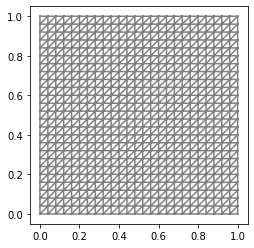

In [4]:
nx = 25
ny = 25
mesh = dl.UnitSquareMesh(25,25)

V = dl.FunctionSpace(mesh, 'CG', 1)
dl.plot(mesh)

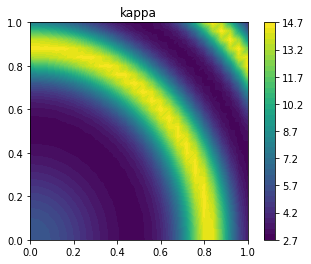

In [30]:
kappa_expr = dl.Expression('1.0 + 5.0*exp(-sin(7*pow(x[0],2) + 6*pow(x[1],2)))', degree=3, domain=mesh)
kappa = dl.interpolate(kappa_expr, V)
cm = dl.plot(kappa)
plt.title('kappa')
plt.colorbar(cm)

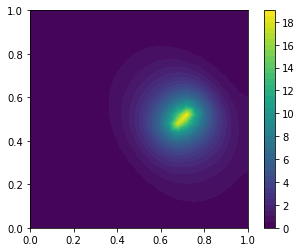

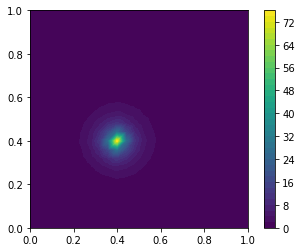

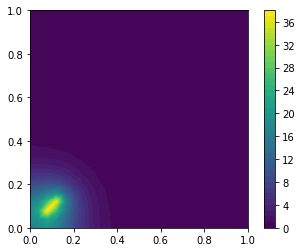

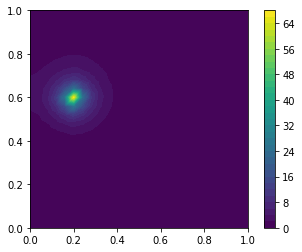

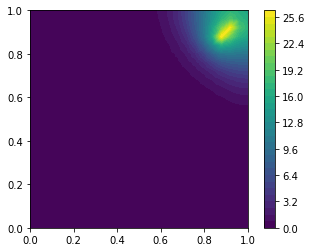

In [46]:
stiffness_form = kappa * dl.inner(dl.grad(dl.TrialFunction(V)), dl.grad(dl.TestFunction(V))) * dl.dx
mass_form = dl.TrialFunction(V) * dl.TestFunction(V) * dl.dx

correlation_length = 0.1
delta = 1.0
gamma = 0.15 * (correlation_length**2) / delta

a_form = gamma * stiffness_form + delta * mass_form
A = dl.assemble(a_form)

A_solver = dl.LUSolver(A)

#

M = dl.assemble(mass_form)
M_solver = dl.LUSolver(M)

#
ps = dl.PointSource(V, dl.Point(0.7, 0.5), 1.0)
b_vec = dl.Function(V).vector()
ps.apply(b_vec)

u = dl.Function(V)
A_solver.solve(u.vector(), b_vec)

plt.figure()
cm = dl.plot(u)
plt.colorbar(cm)

#
ps = dl.PointSource(V, dl.Point(0.4, 0.4), 1.0)
b_vec = dl.Function(V).vector()
ps.apply(b_vec)

u = dl.Function(V)
A_solver.solve(u.vector(), b_vec)

plt.figure()
cm = dl.plot(u)
plt.colorbar(cm)

#
ps = dl.PointSource(V, dl.Point(0.1, 0.1), 1.0)
b_vec = dl.Function(V).vector()
ps.apply(b_vec)

u = dl.Function(V)
A_solver.solve(u.vector(), b_vec)

plt.figure()
cm = dl.plot(u)
plt.colorbar(cm)

#
ps = dl.PointSource(V, dl.Point(0.2, 0.6), 1.0)
b_vec = dl.Function(V).vector()
ps.apply(b_vec)

u = dl.Function(V)
A_solver.solve(u.vector(), b_vec)

plt.figure()
cm = dl.plot(u)
plt.colorbar(cm)

#
ps = dl.PointSource(V, dl.Point(0.9, 0.9), 1.0)
b_vec = dl.Function(V).vector()
ps.apply(b_vec)

u = dl.Function(V)
A_solver.solve(u.vector(), b_vec)

plt.figure()
cm = dl.plot(u)
plt.colorbar(cm)

In [71]:
def apply_A(x_numpy):
    x_petsc = dl.Function(V).vector()
    x_petsc[:] = x_numpy
    y_petsc = dl.Function(V).vector()
    A_solver.solve(y_petsc, M * x_petsc)
    z_petsc = dl.Function(V).vector()
    A_solver.solve(z_petsc, M * y_petsc)
    return (M * y_petsc)[:]

apply_AT = apply_A

def solve_M(x_numpy):
    x_petsc = dl.Function(V).vector()
    x_petsc[:] = x_numpy
    y_petsc = dl.Function(V).vector()
    M_solver.solve(y_petsc, x_petsc)
    return y_petsc[:]

dof_coords = V.tabulate_dof_coordinates()

all_vol, all_mu, all_Sigma = lpsf.impulse_response_moments(apply_AT, solve_M, dof_coords)

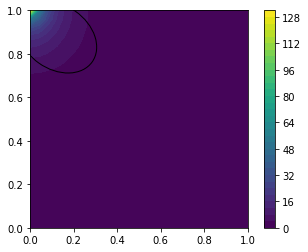

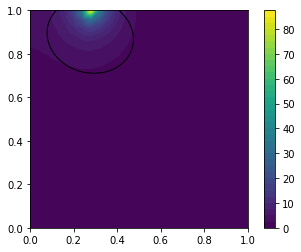

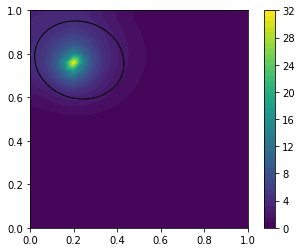

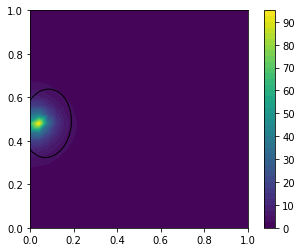

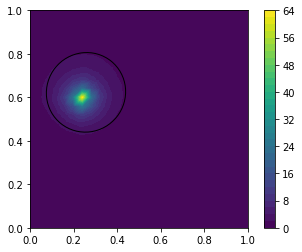

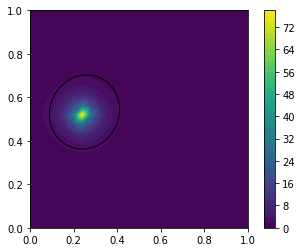

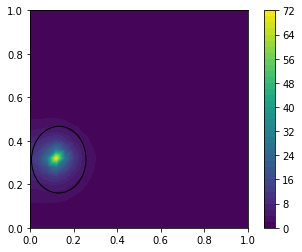

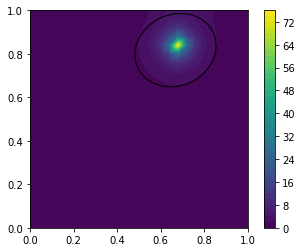

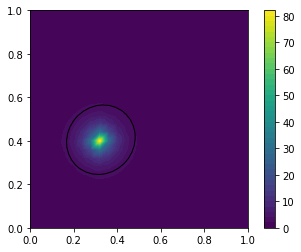

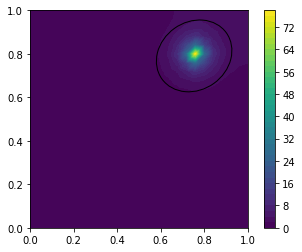

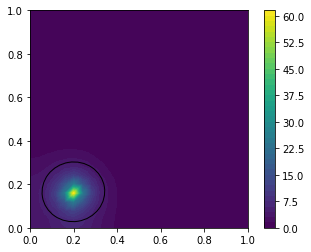

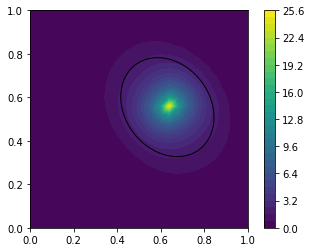

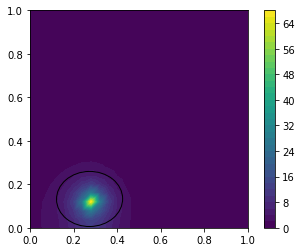

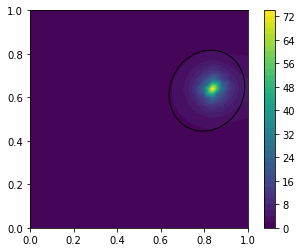

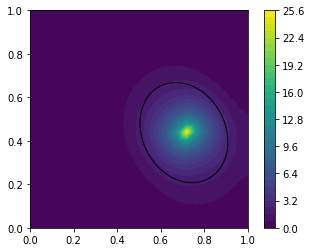

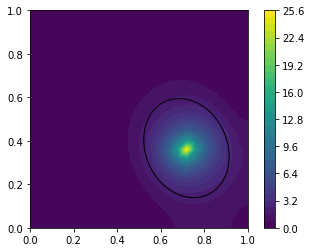

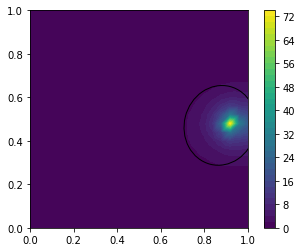

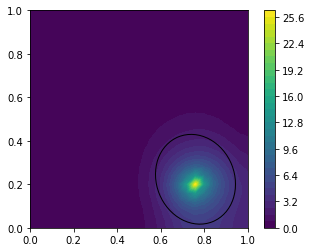

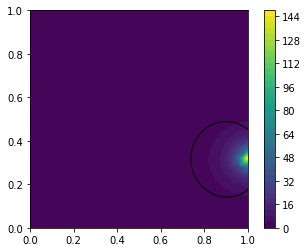

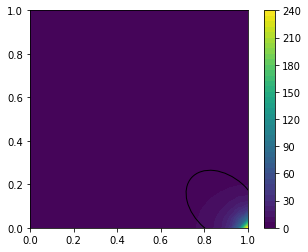

In [81]:
tau=1.5
kk = list(np.linspace(0,V.dim()-1,20, dtype=int))
for k in kk:
    b_vec = dl.Function(V).vector()
    b_vec[k] = 1.0

    u = dl.Function(V)
    u.vector()[:] = solve_M(apply_A(solve_M(b_vec[:])))

    plt.figure()
    cm = dl.plot(u)
    plt.colorbar(cm)

    plot_ellipse(all_mu[k], all_Sigma[k], tau)